# 高分红配对策略

1. 选择分红稳定连续，分红比例超过4%以上的股票
2. 确定上证50（510050）作为基准
3. 通过比对，确定资金投入与ETF还是个股，long-only策略，整体组合的delta不变，融入大的portfolio中
4. 跟踪spread，在spread的波动情况下进入投资
5. 长期持有，根据分红率适时更新Universe，因为是高分红低PE，所以风险可控

优化措施：
1. beta优化调整，通过beta比例确定投资金额
2. 通过moving average进行优化
3. 通过kalman filter进行beta、spread实时跟踪
4. 通过检测验证相关的spread是否stationary，是否normal，是否有效存在heteroskedasticity等

## 原理验证
## Step1：选择股票Universe

In [11]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

import warnings
# 忽略所有警告
warnings.filterwarnings('ignore')


# plt的默认设置
plt.rcParams['figure.figsize'] = [12.0, 8.0]  # 宽度, 高度

plt.rcParams['axes.spines.right']= False
plt.rcParams['axes.spines.top']= False
plt.rcParams['axes.spines.left']= False
plt.rcParams['axes.spines.bottom']=False

plt.rcParams['axes.labelsize'] = 14  # 设置坐标轴标签字体大小
plt.rcParams['axes.titlesize'] = 16  # 设置标题字体大小
plt.rcParams['xtick.labelsize'] = 12  # 设置x轴刻度标签字体大小
plt.rcParams['ytick.labelsize'] = 12  # 设置y轴刻度标签字体大小
plt.rcParams['grid.alpha'] = 1  # 设置网格透明度

plt.rcParams['axes.grid'] = True # 设置网格线

plt.rcParams['legend.fontsize'] = 16 

plt.rcParams['font.family'] = "monospace" # 设置图片字体



In [12]:
# 获得投资的pandas数组
sec_universe = pd.DataFrame.from_csv('sec_universe.csv', index_col = 0)

# 转换为list类型方便处理
sec_universe_list = list(sec_universe.index)

## Step2: 与基准进行对比

In [13]:
# 确定上证50ETF为基准
benchmark = '510050.XSHG'

# 确定一个sec，作为test用
# 工商银行
sec_test = sec_universe_list[16]

# 确定整体时间长度，默认设置为过去200天
ncount = 200

# 确定end_date
end_date='2024-03-25'

In [14]:
# 获取价格
price_sec = get_price(sec_test, count = ncount, end_date=end_date, frequency='daily', fields=['close'])

price_benchmark = get_price(benchmark, count = ncount, end_date=end_date, frequency='daily', fields=['close'])

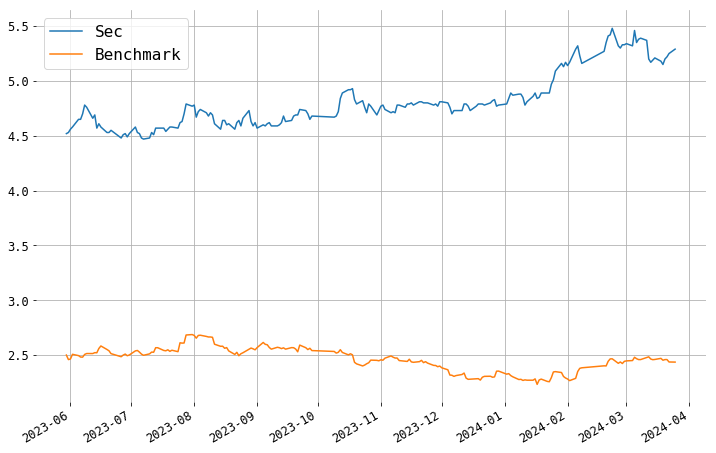

In [15]:
# 进行画图
pd.concat([price_sec, price_benchmark], axis=1).plot()
plt.legend(['Sec', 'Benchmark']);

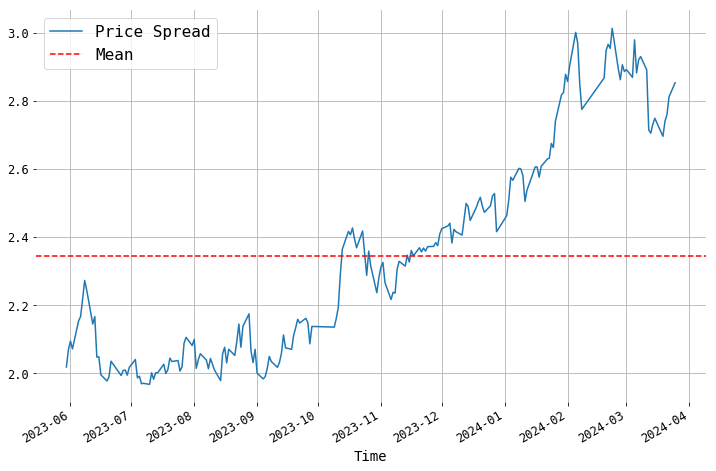

In [16]:
# 画出价格变化趋势
(price_sec - price_benchmark).plot() # Plot the spread
plt.axhline((price_sec - price_benchmark).mean().values[0], color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean']);

In [17]:
# 进行cointegration检测
score, pvalue, _ = coint(price_sec, price_benchmark)
pvalue

0.7970055562601713

## Step3：计算spread

1. 使用线性拟合的beta进行调整，对比不进行调整，确实有所差别，更加陡峭剧烈
2. 使用了zscore的确和不使用zscore有所差别，更加陡峭剧烈

In [18]:
price_benchmark = sm.add_constant(price_benchmark)
results = sm.OLS(price_sec, price_benchmark).fit()

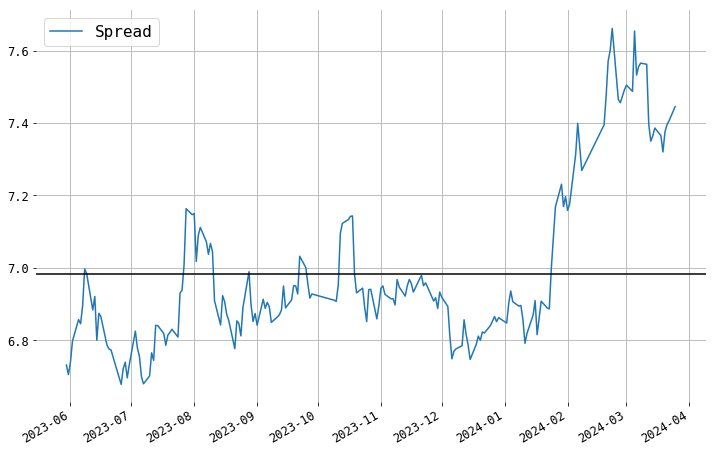

In [19]:
b = results.params['close']

spread = price_sec['close'] - b * price_benchmark['close']
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

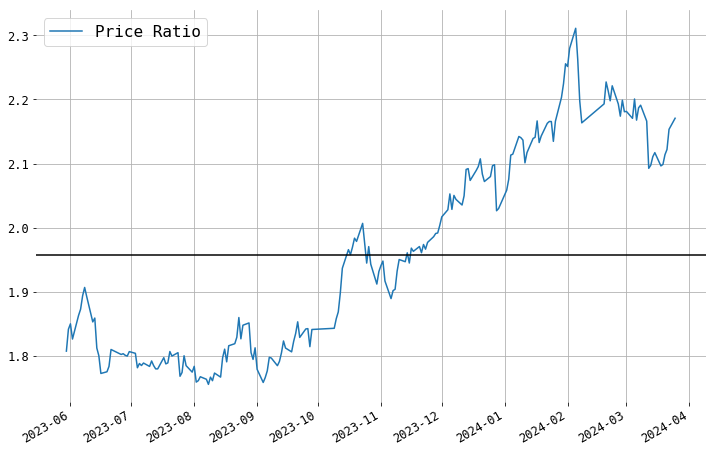

In [20]:
ratio = price_sec['close']/price_benchmark['close']
ratio.plot()
plt.axhline(ratio.mean(), color='black')
plt.legend(['Price Ratio']);

In [21]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

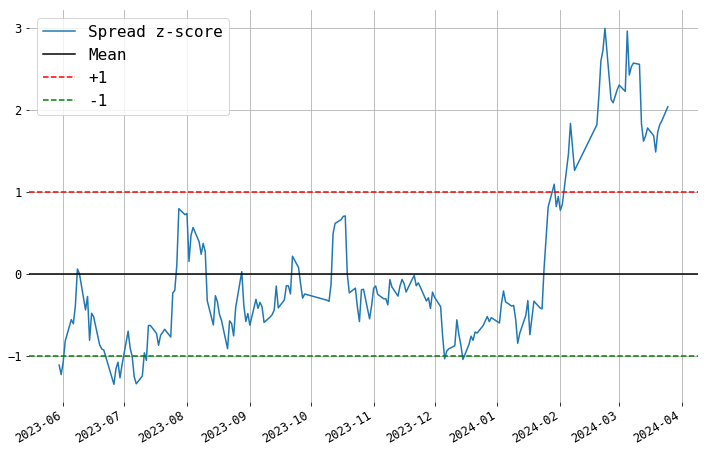

In [22]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

## Step4：使用rolling windows进行跟踪

1. 因为版本问题，rolling ols使用pyfinance进行
2. beta不稳定，前期数据不足，数值为负，后期转为正数
3. windows设置为30天，则beta不稳定，偏离经验值，如果设置为100天，则beta较为稳定，符合经验值

In [23]:
from pyfinance.ols import PandasRollingOLS

# 设置windows大小
n_windows = 100

ret = PandasRollingOLS(y=price_sec['close'], x=price_benchmark['close'], window=n_windows)

rolling_beta = ret.beta

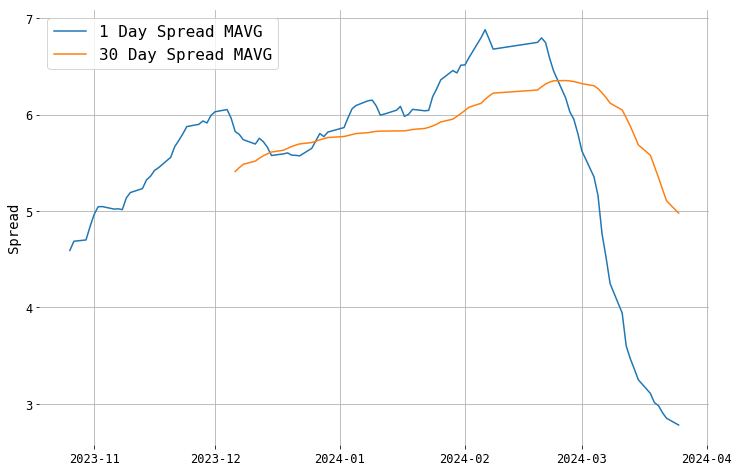

In [24]:
spread = price_sec['close'] - rolling_beta['feature1'] * price_benchmark['close']
spread.name = 'spread'

spread_mavg1 = spread.rolling(1).mean()
spread_mavg1.name = 'spread 1d mavg'

# Get the 30 day moving average
spread_mavg30 = spread.rolling(30).mean()
spread_mavg30.name = 'spread 30d mavg'

plt.plot(spread_mavg1.index, spread_mavg1.values)
plt.plot(spread_mavg30.index, spread_mavg30.values)

plt.legend(['1 Day Spread MAVG', '30 Day Spread MAVG'])

plt.ylabel('Spread');

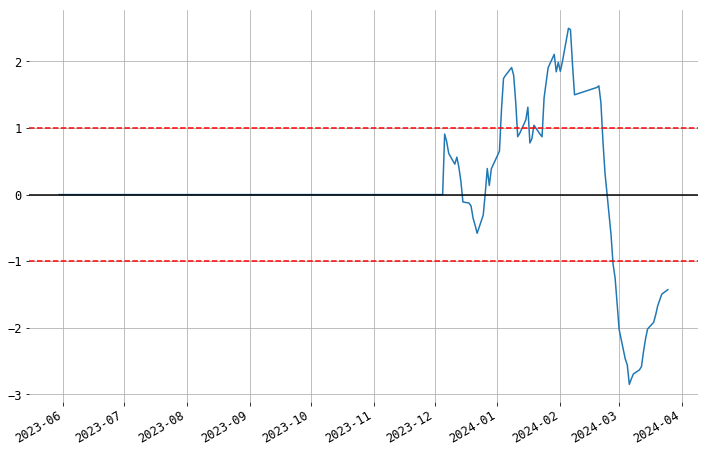

In [34]:
# Take a rolling 30 day standard deviation
std_30 = spread.rolling(30).std()
std_30.name = 'std 30d'

# Compute the z score for each day
zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30
zscore_30_1.fillna(0,inplace = True)
zscore_30_1.name = 'z-score'
zscore_30_1.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='red', linestyle='--')


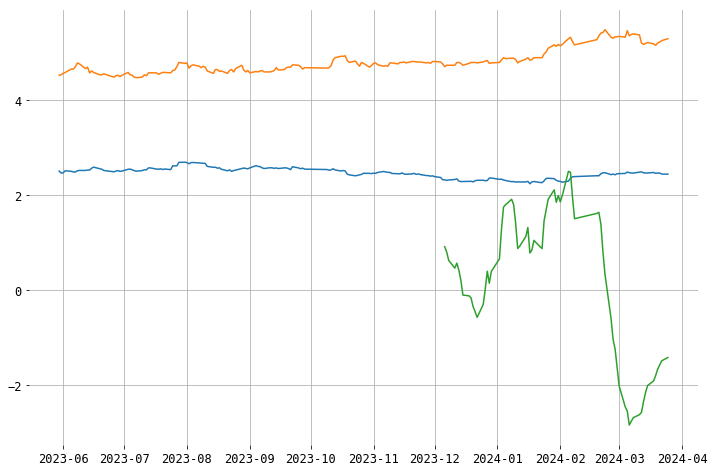

In [31]:
# Plot the prices scaled down along with the negative z-score
# just divide the stock prices by 10 to make viewing it on the plot easier
plt.plot(price_benchmark['close'].index, price_benchmark['close'].values)
plt.plot(price_sec['close'].index, price_sec['close'].values)
plt.plot(zscore_30_1.index, zscore_30_1.values)

In [38]:
# 检测是否正态分布
from statsmodels.stats.stattools import jarque_bera

normality_pvalue = jarque_bera(zscore_30_1)[1]
normality_pvalue

7.9628113607145e-12

In [40]:
# 检测是否stationary
from statsmodels.tsa.stattools import coint, adfuller

stationary_pvalue = adfuller(zscore_30_1)[1]
stationary_pvalue

0.0363495199501122

## 逐个评估
### 最终目的是生成zscore分布图，确实否是符合stationary，normality

In [103]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

import warnings
# 忽略所有警告
warnings.filterwarnings('ignore')


# plt的默认设置
plt.rcParams['figure.figsize'] = [12.0, 8.0]  # 宽度, 高度

plt.rcParams['axes.spines.right']= False
plt.rcParams['axes.spines.top']= False
plt.rcParams['axes.spines.left']= False
plt.rcParams['axes.spines.bottom']=False

plt.rcParams['axes.labelsize'] = 14  # 设置坐标轴标签字体大小
plt.rcParams['axes.titlesize'] = 16  # 设置标题字体大小
plt.rcParams['xtick.labelsize'] = 12  # 设置x轴刻度标签字体大小
plt.rcParams['ytick.labelsize'] = 12  # 设置y轴刻度标签字体大小
plt.rcParams['grid.alpha'] = 1  # 设置网格透明度

plt.rcParams['axes.grid'] = True # 设置网格线

plt.rcParams['legend.fontsize'] = 16 

plt.rcParams['font.family'] = "monospace" # 设置图片字体

In [104]:
# 获得投资的pandas数组
sec_universe = pd.DataFrame.from_csv('sec_universe.csv', index_col = 0)

# 转换为list类型方便处理
sec_universe_list = list(sec_universe.index)

# 确定整体时间长度，默认设置为过去200天
ncount = 600

# 确定end_date
end_date='2024-03-25'

# 确定上证50ETF为基准
benchmark = '510050.XSHG'

# 确定一个sec，作为test用
# 工商银行
sec_code = sec_universe_list[10]
sec_code = '000157.XSHE'

In [105]:
# 获取价格
price_sec = get_price(sec_code, count = ncount, end_date=end_date, frequency='daily', fields=['close'])['close']
price_benchmark = get_price(benchmark, count = ncount, end_date=end_date, frequency='daily', fields=['close'])['close']

# 设置series的名称
price_sec.name = sec_code
price_benchmark.name = benchmark

In [106]:
from pyfinance.ols import PandasRollingOLS

# 设置windows大小
n_windows = 100

# 进行线性拟合
ret = PandasRollingOLS(y=price_sec, x=price_benchmark, window=n_windows)

# 赋值
rolling_beta = pd.Series(ret.beta.iloc[:,0])
rolling_beta.name = 'rolling_beta'

In [107]:
# 设置不同的周期窗口
short_window = 1
long_window =40


spread = price_sec - rolling_beta * price_benchmark
spread.name = 'spread'

spread_mavg_short = spread.rolling(short_window).mean()
spread_mavg_short.name = 'spread_short_mavg'

# Get the 30 day moving average
spread_mavg_long = spread.rolling(long_window).mean()
spread_mavg_long.name = 'spread_long_mavg'

In [108]:
# Take a rolling 30 day standard deviation
std_long = spread.rolling(long_window).std()
std_long.name = 'std_long'

# Compute the z score for each day
zscore_long_short = (spread_mavg_short - spread_mavg_long)/std_long
zscore_long_short.fillna(0,inplace = True)
zscore_long_short.name = 'z-score'

In [109]:
# 检测是否正态分布
from statsmodels.stats.stattools import jarque_bera

normality_pvalue = jarque_bera(zscore_long_short)[1]
normality_pvalue

9.342918629323115e-07

In [110]:
# 检测是否stationary
from statsmodels.tsa.stattools import coint, adfuller

stationary_pvalue = adfuller(zscore_long_short)[1]
stationary_pvalue

0.0036203869683166397

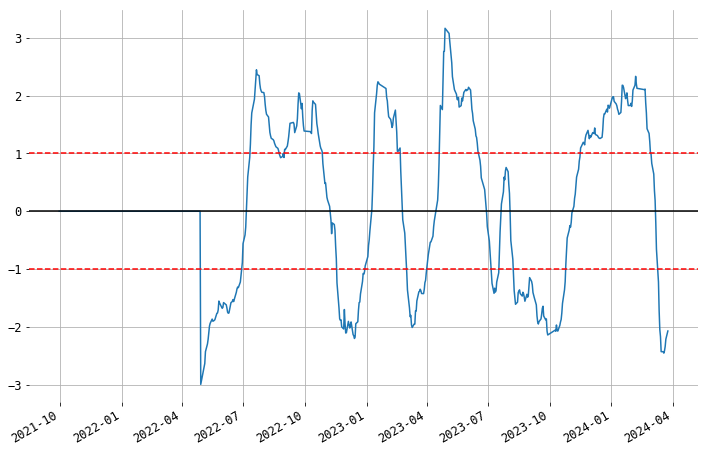

In [111]:
# 画图
zscore_long_short.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='red', linestyle='--')

## 一次性验证

In [94]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

import warnings
# 忽略所有警告
warnings.filterwarnings('ignore')


# plt的默认设置
plt.rcParams['figure.figsize'] = [12.0, 8.0]  # 宽度, 高度

plt.rcParams['axes.spines.right']= False
plt.rcParams['axes.spines.top']= False
plt.rcParams['axes.spines.left']= False
plt.rcParams['axes.spines.bottom']=False

plt.rcParams['axes.labelsize'] = 14  # 设置坐标轴标签字体大小
plt.rcParams['axes.titlesize'] = 16  # 设置标题字体大小
plt.rcParams['xtick.labelsize'] = 12  # 设置x轴刻度标签字体大小
plt.rcParams['ytick.labelsize'] = 12  # 设置y轴刻度标签字体大小
plt.rcParams['grid.alpha'] = 1  # 设置网格透明度

plt.rcParams['axes.grid'] = True # 设置网格线

plt.rcParams['legend.fontsize'] = 16 

plt.rcParams['font.family'] = "monospace" # 设置图片字体

In [95]:
# 获得投资的pandas数组
sec_universe = pd.DataFrame.from_csv('sec_universe.csv', index_col = 0)

# 转换为list类型方便处理
sec_universe_list = list(sec_universe.index)

# 确定整体时间长度，默认设置为过去200天
ncount = 600

# 确定end_date
end_date='2024-03-25'

# 确定上证50ETF为基准
benchmark = '510050.XSHG'


# 设置回归beta的窗口大小
from pyfinance.ols import PandasRollingOLS

# 设置windows大小
n_windows = 100


# 设置不同的周期窗口
short_window = 1
long_window =40


from statsmodels.stats.stattools import jarque_bera

from statsmodels.tsa.stattools import coint, adfuller


In [112]:
# 开始遍历universe，逐个股票进行验证
inspection_ret = {}

for sec_code in sec_universe_list:
    print(sec_code)

    inspection_ret[sec_code] = []
    
    # 初始化，设置为0
    price_sec = pd.Series()
    price_benchmark = pd.Series()
    # 获取价格
    price_sec = get_price(sec_code, count = ncount, end_date=end_date, frequency='daily', fields=['close'])['close']
    price_benchmark = get_price(benchmark, count = ncount, end_date=end_date, frequency='daily', fields=['close'])['close']

    # 设置series的名称
    price_sec.name = sec_code
    price_benchmark.name = benchmark
    
    
    # 进行线性拟合
    ret = PandasRollingOLS(y=price_sec, x=price_benchmark, window=n_windows)

    # 赋值
    rolling_beta = pd.Series()
    rolling_beta = pd.Series(ret.beta.iloc[:,0])
    rolling_beta.name = 'rolling_beta'
    
    
    # 计算spread
    spread = pd.Series()
    
    spread = price_sec - rolling_beta * price_benchmark
    spread.name = 'spread'

    spread_mavg_short = pd.Series()

    spread_mavg_short = spread.rolling(short_window).mean()
    spread_mavg_short.name = 'spread_short_mavg'

    # Get the 30 day moving average
    spread_mavg_long = pd.Series()
    
    spread_mavg_long = spread.rolling(long_window).mean()
    spread_mavg_long.name = 'spread_long_mavg'

    
    # Take a rolling 30 day standard deviation
    std_long = pd.Series()
    
    std_long = spread.rolling(long_window).std()
    std_long.name = 'std_long'

    # Compute the z score for each day
    zscore_long_short = pd.Series()

    zscore_long_short = (spread_mavg_short - spread_mavg_long)/std_long
    zscore_long_short.fillna(0,inplace = True)
    zscore_long_short.name = 'z-score'
    
#     ret[sec_code].append(zscore_long_short.values[-1])
    inspection_ret[sec_code].append(zscore_long_short.values[-1])

    
    
    # 检测是否正态分布
    normality_pvalue = 1
    normality_pvalue = jarque_bera(zscore_long_short)[1]
    normality_pvalue
    
    inspection_ret[sec_code].append(normality_pvalue)
    
    
    stationary_pvalue = 1
    stationary_pvalue = adfuller(zscore_long_short)[1]
    stationary_pvalue
    
    inspection_ret[sec_code].append(stationary_pvalue)
    

000157.XSHE
000651.XSHE
000895.XSHE
000983.XSHE
600028.XSHG
600039.XSHG
600188.XSHG
600585.XSHG
600919.XSHG
601006.XSHG
601009.XSHG
601088.XSHG
601169.XSHG
601225.XSHG
601288.XSHG
601328.XSHG
601398.XSHG
601699.XSHG
601857.XSHG
601919.XSHG
601939.XSHG
601988.XSHG
601998.XSHG


In [117]:
pd.DataFrame.from_dict(inspection_ret,orient='index',columns = ['zscore','normality_pvalue','stationary_pvalue'])

,zscore,normality_pvalue,stationary_pvalue
000157.XSHE,-2.069030,9.342919e-07,3.620387e-03
000651.XSHE,-2.073667,1.643878e-04,3.168747e-03
000895.XSHE,-2.115925,1.130306e-02,5.422418e-05
000983.XSHE,-2.084823,1.253490e-02,4.861338e-03
600028.XSHG,-1.481079,4.343910e-03,1.184057e-03
600039.XSHG,1.084973,6.550360e-04,4.363874e-04
600188.XSHG,-1.940472,3.628527e-03,2.042593e-02
600585.XSHG,1.774319,8.335362e-03,2.802483e-03
600919.XSHG,-2.036519,3.753618e-05,5.745478e-04
601006.XSHG,-1.045840,5.070130e-03,1.604378e-02
